# Introduction to PerMaViss

This notebook introduces some of the objects and terminology used in PerMaViss. It explains in detail the used data structures, as well as the algorithmic intricacies of the persistence mayer vietoris algorithm.

© Copyright 2021, Álvaro Torras Casas, part of PerMaViss project.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(10)


In [2]:
mpl.font_manager.FontManager(size=20)

# 1. Basic Persistent Homology using PerMaViss

### 1.1. Generating a Random Circle

We start by importing the necessary modules

In [3]:
import permaviss

from permaviss.sample_point_clouds.examples import random_circle, take_sample

We sample 100 points around a noisy circle of radius 1. Then we take a subsample of 20 points by using the min-max algorithm.

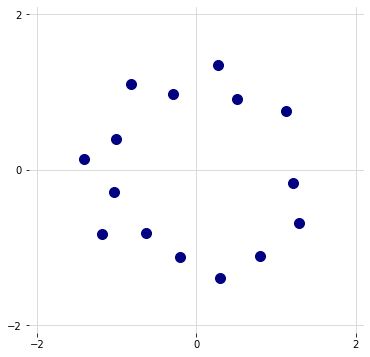

In [4]:
X = random_circle(100, 1, 0.5, seed=10)    # random points around a circle of radius 1
X = take_sample(X, 15, seed=4)   # subsample by using the min-max algorithm

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6,6))

def plot_subpoints_circle(point_cloud, xlim, xticks, color, axis):
    axis.set(frame_on=False)
    axis.grid(c='lightgray')
    axis.scatter(point_cloud[:,0], point_cloud[:,1], s=100, c=color)
    axis.set_xlim(xlim)
    axis.set_ylim([-2.1,2.1])
    axis.set_xticks(xticks)
    axis.set_yticks([-2,0,2])
    

plot_subpoints_circle(X, [-2.1,2.1], [-2,0,2], 'navy', ax)  
plt.savefig("figures/sample_circle.png", pad_inches=0.05, bbox_inches=None)

### 1.2. Computing the Vietoris-Rips complex

First, we import the modules implementing the construction of filtered complexes. We also import a scipy submodule for computing the distance matrices.

In [5]:
from permaviss.simplicial_complexes.vietoris_rips import vietoris_rips

import scipy.spatial.distance as dist

Dist_X = dist.squareform(dist.pdist(X))

Then we proceed to compute the Vietoris-Rips complex on top of $X$, we set the maximum filtration radius at value 4 and the maximum dimension at value 3. Notice that in the following example $C$ is a list of lists whose first entry indicates the number of vertices, the filtration values are stored on a separated list of lists $R$; both $C$ and $R$ share the same indexing system: [dimension][simplex index]. Simplices in $C$ are stored by the collection of vertices: $[v_1, v_2 ..., v_n]$.

In [6]:
max_r = 4
max_dim = 3
C, R = vietoris_rips(Dist_X, max_r, max_dim)
print("Number of vertices: " + str(C[0]))
print("=======================")
for dim, C_dim in enumerate(C):
    if dim > 0:
        print("Dimension: " + str(dim))
        print("=======================")
        for spx_idx, simplex in enumerate(C_dim):
            print(str(C_dim[spx_idx]) + " --> " + "{:.3f}".format(R[dim][spx_idx]))
            if spx_idx > 5: # limit the display to 5 simplices per dimension
                print("...\n")
                break
            

Number of vertices: 15
Dimension: 1
[ 5 14] --> 0.484
[ 4 13] --> 0.499
[ 7 12] --> 0.518
[ 6 11] --> 0.531
[ 2 10] --> 0.547
[6 9] --> 0.560
[ 1 11] --> 0.561
...

Dimension: 2
[ 1  8 11] --> 0.665
[ 5  8 14] --> 0.685
[ 4 10 13] --> 0.801
[ 2 10 14] --> 0.919
[3 6 9] --> 1.000
[1 5 8] --> 1.002
[ 3  7 12] --> 1.026
...

Dimension: 3
[ 1  6  8 11] --> 1.185
[ 1  5  8 11] --> 1.236
[ 1  5  8 14] --> 1.248
[ 1  5 11 14] --> 1.269
[ 1  8 11 14] --> 1.269
[ 5  8 11 14] --> 1.269
[ 2  4 10 13] --> 1.343
...



### 1.3. Computing Classic Persistent Homology

In this section we compute persistent homology of $C$ by using the classic matrix approach with the twist implementation. 

In [7]:
import time
from permaviss.simplicial_complexes.differentials import complex_differentials
from permaviss.persistence_algebra.PH_classic import persistent_homology

We compute the differentials of $C$ on the base field $Z$ mod $5$. Afterwards we compute persistent homology. Notice that the current implementation is slow.

In [8]:
p = 5 # perform computations on Z mod 5

start = time.time()
Diff = complex_differentials(C, p=5)
end = time.time()
print("Computing differentials took " + "{:.2f}".format(end - start) + " seconds.")
start = end
Hom, Im, PreIm = persistent_homology(Diff, R, max_r, p)
end = time.time()
print("Computing persistent homology took " + "{:.2f}".format(end - start) + " seconds.")

Computing differentials took 11.26 seconds.
Computing persistent homology took 39.42 seconds.


When computing persistent homology we recover $Hom$, $Im$ and $PreIm$, which store persistent homology classes, image representatives and preimages. These are lists indexed by dimension which contain information as barcode basis objects.

In [9]:
print("Hom length: " + str(len(Hom)) + "\n")
print("Hom[1] type: " + str(type(Hom[1])) + "\n")
print("Hom[1].barcode: \n" + str(Hom[1].barcode) + "\n")
print("Hom[1].coordinates.T: \n" + str(Hom[1].coordinates.T) + "\n")

print("Im length: " + str(len(Im)) + "\n")
print("Im[1] type: " + str(type(Im[1])) + "\n")
print("Im[1].barcode: \n" + str(Im[1].barcode[:3])[:-1] + "\n" + " ...\n" + " " + str(Im[1].barcode[-3:])[1:-1] + "]" + "\n") # limit output
print("Im[1].coordinates.T: \n" + str(Im[1].coordinates.T) + "\n")

print("PreIm length: " + str(len(PreIm)) + "\n")
print("PreIm[1] type: " + str(type(PreIm[1])) + "\n")
print("PreIm[1]: \n" + str(PreIm[1]) + "\n") 

Hom length: 4

Hom[1] type: <class 'permaviss.persistence_algebra.barcode_bases.barcode_basis'>

Hom[1].barcode: 
[[0.93966454 1.94179243]]

Hom[1].coordinates.T: 
[[0. 4. 4. 4. 0. 1. 0. 0. 0. 4. 1. 1. 1. 1. 4. 0. 0. 1. 4. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Im length: 4

Im[1] type: <class 'permaviss.persistence_algebra.barcode_bases.barcode_basis'>

Im[1].barcode: 
[[0.6648009  4.        ]
 [0.68466353 4.        ]
 [0.80052124 4.        ]
 ...
 [2.77053568 4.        ]
 [2.80922942 4.        ]
 [2.83070175 4.        ]]

Im[1].coordinates.T: 
[[0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 4. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 4. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 4. 0. 1.]]

PreIm length: 4

PreIm[1] type: <class 'numpy.ndarray'>

PreI

We may plot the obtained persistence diagram and representatives by using the information contained in $Hom$.

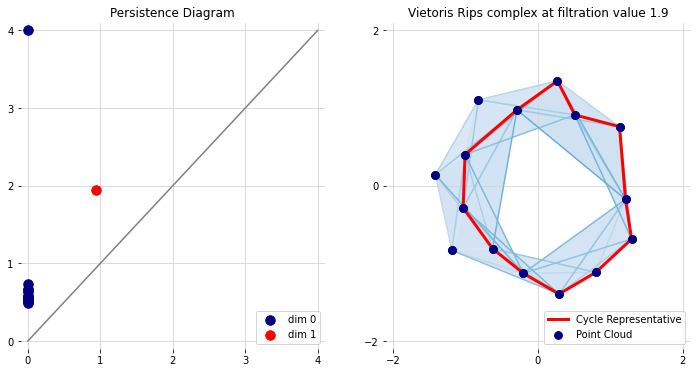

In [10]:
blues = mpl.cm.get_cmap('Blues') # get colormap for plotting
max_plotting_r = 1.9 # set maximum filtration for plotting purposes

fig = plt.figure(figsize=(12,6))

ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

# plot point persistence diagram #################################################

ax0.set(frame_on=False)
ax0.grid(c='lightgray')

barcode0 = Hom[0].barcode
ax0.scatter(barcode0[:,0], barcode0[:,1], c='navy', s=90, label='dim 0', zorder=3)

barcode1 = Hom[1].barcode
ax0.scatter(barcode1[:,0], barcode1[:,1], c='red', s=90, label='dim 1', zorder=3)

ax0.plot([0, max_r], [0, max_r], c='gray') # plot diagonal 

# set axes layout
ax0.set_xlim([-0.1, max_r + 0.1])
ax0.set_ylim([-0.1, max_r + 0.1])
ax0.set_xticks(range(5))
ax0.set_yticks(range(5))
#set labels 
ax0.set_title("Persistence Diagram")
# avoid repeating labels on legend 
handles, labels = ax0.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # dictionary deletes repeating labels
ax0.legend(by_label.values(), by_label.keys(), loc='lower right')

# plot cycle representative #################################################

def plot_complex_noisy_circle(C, R, max_plotting_r, point_cloud, axis):
    axis.set(frame_on=False)
    axis.grid(c='lightgray')

    # plot 2D simplices
    for idx, triangle in enumerate(C[2]):
        if R[2][idx] < max_plotting_r:
            vertices = point_cloud[triangle]
            axis.fill(vertices[:, 0], vertices[:, 1], facecolor=blues(R[2][idx]/(5*max_plotting_r)))
    # plot edges 
    for idx, edge in enumerate(C[1]):
        if R[1][idx] < max_plotting_r:
            vertices = point_cloud[edge]
            axis.plot(vertices[:, 0], vertices[:, 1], color=blues(R[1][idx]/(2*max_plotting_r)))
             
    # scatter plot 
    axis.scatter(point_cloud[:,0], point_cloud[:,1], s=60, c='navy', zorder=2.5, label='Point Cloud')

    # set axes layout
    axis.set_xlim([-2.1,2.1])
    axis.set_ylim([-2.1,2.1])
    axis.set_xticks([-2,0,2])
    axis.set_yticks([-2,0,2])

plot_complex_noisy_circle(C, R, max_plotting_r, X, ax1)            

# add cycle representative
for idx, coeff in enumerate(Hom[1].coordinates[:, 0]):
    if coeff != 0:
        edge = C[1][idx] # get edge from index
        vertices = X[edge] # recover vertices
        ax1.plot(vertices[:, 0], vertices[:, 1], color='red', linewidth=3, label='Cycle Representative')
        
# scatter plot 
ax1.scatter(X[:,0], X[:,1], s=60, c='navy', zorder=2.5, label='Point Cloud')

#set labels 
ax1.set_title("Vietoris Rips complex at filtration value " + str(max_plotting_r))
# avoid repeating labels on legend 
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # dictionary deletes repeating labels
ax1.legend(by_label.values(), by_label.keys(), loc='lower right')

# save figure ########################################################

plt.savefig("figures/diagram_rep_circle.png", pad_inches=0.05, bbox_inches=None)

In [11]:
np.max(np.array([[1,2],[3,4],[-1,-5]]))

4

# 2. Persistence Algebra

### 2.1. Barcode Bases

Barcode bases store bases associated to persistence modules. We always assume that intervals associated with generators are right-open. Let us start by creating a barcode basis object whose associated barcode contains the bars $[0,2)$, $[0,1)$, $[2,3)$ and $[2,2)$. 

In [12]:
from permaviss.persistence_algebra.barcode_bases import barcode_basis

bars = np.array([[1,2],[1,4],[0,3],[2,2]])
base1 = barcode_basis(bars)
print("Created base1\n")
print("Dimension of base1: " + str(base1.dim) + "\n")
print(base1)

Created base1

Dimension of base1: 3

Barcode basis
[[1 2]
 [1 4]
 [0 3]]



Notice that the trivial interval $[2,2)$ has been authomatically deleted. We can use the <code>barcode_basis.sort()</code> method to sort the intervals according to the standard interval order.

In [13]:
base1.sort()
print(base1)

Barcode basis
[[0 3]
 [1 4]
 [1 2]]



We can recover the persistence values at which some change happens at <code>base1</code> barcodes by using 
the method <code>barcode_basis.changes_list()</code>. Then, we might use the methods 
<code>barcode_basis.birth()</code> and <code>barcode_basis.death()</code> to know the indices of the generators 
which are being born or dying.

In [14]:
change_values = base1.changes_list()
print("Change value list: " + str(change_values) + "\n")
for x in change_values:
    print("Filtration Value: " + str(x))
    print("Generators being born: " + str(base1.birth(x)))
    print("Generators dying: " + str(base1.death(x)) + "\n")

Change value list: [0 1 2 3 4]

Filtration Value: 0
Generators being born: [0]
Generators dying: []

Filtration Value: 1
Generators being born: [1 2]
Generators dying: []

Filtration Value: 2
Generators being born: []
Generators dying: [2]

Filtration Value: 3
Generators being born: []
Generators dying: [0]

Filtration Value: 4
Generators being born: []
Generators dying: [1]



We might create a barcode basis object by referencing a previously created barcode basis object. This introduces coordinates. In the following example we create a new base referencing the previously created <code>base1</code>. Notice that when printing the created base two arrays are displayed: the associated barcode as well as the corresponding coordinates.

In [15]:
barcode =[[1,3], [2,4]]
coordinates = np.array([[1,0,-1], [1, 1, 0]]).T
base2 = barcode_basis(barcode, prev_basis=base1, coordinates=coordinates)
print(str(base2) + "\n")
print("We might also read this by using object attributes:")
print("base2.barcode:\n" + str(base2.barcode))
print("base2.coordinates:\n" + str(base2.coordinates))

Barcode basis
[[1 3]
 [2 4]]
[[ 1  1]
 [ 0  1]
 [-1  0]]


We might also read this by using object attributes:
base2.barcode:
[[1 3]
 [2 4]]
base2.coordinates:
[[ 1  1]
 [ 0  1]
 [-1  0]]


**Remark:** Although one might use coordinates to refer to a submodule base, this does not need to be the case. Often we will rather refer to the base of a quotient $N/K$ from a given sequence $K \subseteq N \subseteq M$, where the given previous basis will be that of $M$. This is important because the choice of coordinates is always limited by the setup, currently <code>PerMaViss</code> **does not check** whether the given coordinates are valid in this sense; so one needs to be careful when using the functions in persistence algebra directly.

### 2.2. The ImageKernel algorithm

We will now consider a pair of persistence modules $M$ and $N$ together with a persistence morphism $f:M\rightarrow N$.

In [16]:
from permaviss.persistence_algebra.image_kernel import image_kernel

base_M = barcode_basis([[0, 4], [0, 2], [1, 4], [1, 3]])
base_N = barcode_basis([[0, 3], [0, 2], [0, 2]])
F = np.array([[0, 0, 0, 1], [4, 0, 1, 3], [1, 0, 1, 4]])
Im, Ker, PreIm = image_kernel(base_M, base_N, F, p=5)

print("Im:")
print(str(Im) + "\n")
print("Ker:")
print(str(Ker) + "\n")
print("PreIm:")
print(str(PreIm) + "\n")

Im:
Barcode basis
[[0. 2.]
 [1. 3.]
 [1. 2.]]
[[0 1 0]
 [4 0 2]
 [1 0 0]]


Ker:
Barcode basis
[[0. 2.]
 [2. 4.]
 [2. 4.]]
[[0. 1. 4.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


PreIm:
[[1. 2. 4.]
 [0. 0. 0.]
 [0. 4. 1.]
 [0. 1. 0.]]



Let us plot some of this information so that it makes more sense:

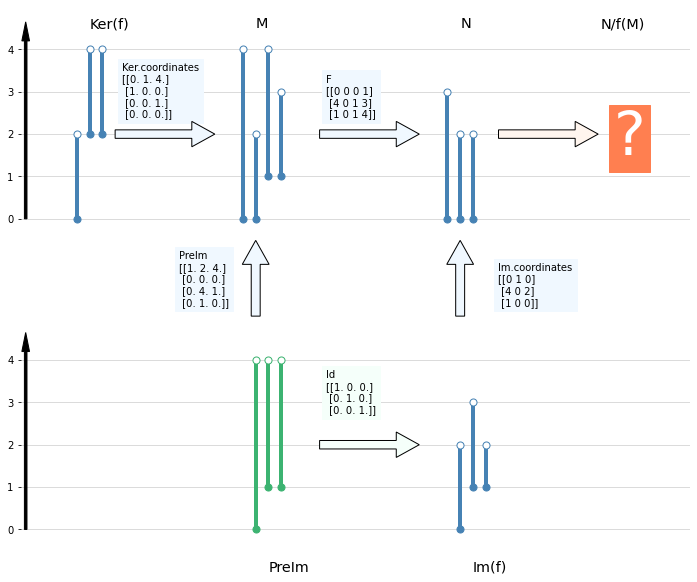

In [17]:
def plot_barcodes(barcode, x_pos, ax, color):
    for bar in barcode:
        ax.plot([x_pos, x_pos], [bar[0], bar[1]], linewidth=4, c=color, zorder=2.5)
        ax.scatter([x_pos], [bar[0]], s=50, c=color, zorder=3)
        ax.scatter([x_pos], [bar[1]], s=50, facecolors='white', edgecolors=color, zorder=3)
        x_pos+=0.5
    return x_pos

fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[3,1,3], hspace=0)

ax0 = fig.add_subplot(gs[0,0])
axm = fig.add_subplot(gs[1,0])
ax1 = fig.add_subplot(gs[2,0])

# plot sequence ker(f) -->  M  --> N --> N/f(M) ##############################################################
ax0.set(frame_on=False)
ax0.grid(c='lightgray')
ax0.arrow(0, 0, 0, 4.2, width=0.1, color='black', zorder=2.5)
ax0.set_xticks([])
ax0.set_yticks(range(5))
ax0.set_xlim([-0.2,26])
ax0.set_ylim([-0.5,5])
# plot ker(f)
x_pos = 2
ax0.text(x_pos+0.5, 4.5, "Ker(f)", fontsize='x-large')
x_pos = plot_barcodes(Ker.barcode, x_pos, ax0, 'steelblue')
ax0.arrow(x_pos, 2, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
ax0.text(x_pos+0.25, 2.4, "Ker.coordinates\n" + str(Ker.coordinates), backgroundcolor='aliceblue', zorder=2)
# plot M
x_pos+=5
ax0.text(x_pos+0.5, 4.5, "M", fontsize='x-large')
x_pos = plot_barcodes(base_M.barcode, x_pos, ax0, 'steelblue')
x_pos+=1
ax0.text(x_pos+0.25, 2.4, "F\n" + str(F), backgroundcolor='aliceblue', zorder=2)
ax0.arrow(x_pos, 2, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot N
x_pos+=5
ax0.text(x_pos+0.5, 4.5, "N", fontsize='x-large')
x_pos = plot_barcodes(base_N.barcode, x_pos, ax0, 'steelblue')
ax0.arrow(x_pos+0.5, 2, 3, 0, width=0.2, zorder=2.5, facecolor='seashell')
# plot N/f(M)
x_pos+=4
ax0.text(x_pos+0.5, 4.5, "N/f(M)", fontsize='x-large')
ax0.text(x_pos+1, 1.5, "?", fontsize=60, backgroundcolor='coral', color='white')

# plot middle 
axm.set(frame_on=False)
axm.set_xticks([])
axm.set_yticks([])
axm.set_xlim([-0.2,26])
axm.set_ylim([-0.1, 5])
x_pos=9
axm.text(x_pos-3, 0.7, "PreIm\n" + str(PreIm), backgroundcolor='aliceblue')
axm.arrow(x_pos, 0, 0, 3.4, width=0.35, zorder=3, facecolor='aliceblue')
x_pos+=8
axm.text(x_pos+1.5, 0.7, "Im.coordinates\n" + str(Im.coordinates), backgroundcolor='aliceblue')
axm.arrow(x_pos, 0, 0, 3.4, width=0.35, zorder=3, facecolor='aliceblue')

# plot sequence Im(f) --> N <--> N* <-- Coker(f) #####################################################
ax1.set(frame_on=False)
ax1.grid(c='lightgray')
ax1.arrow(0, 0, 0, 4.2, width=0.1, color='black', zorder=2.5)
ax1.set_xticks([])
ax1.set_yticks(range(5))
ax1.set_xlim([-0.2,26])
ax1.set_ylim([-0.5,5])
# plot Im(f)
x_pos=9
preim_barcode = np.array([[0,4],[1,4],[1,4]])
ax1.text(x_pos+0.5, -1, "PreIm", fontsize='x-large')
x_pos = plot_barcodes(preim_barcode, x_pos, ax1, 'mediumseagreen')
x_pos+=1
ax1.arrow(x_pos, 2, 3, 0, width=0.2, zorder=2.5, facecolor='mintcream')
ax1.text(x_pos+0.25, 2.75, "Id\n" + str(np.identity(3)), backgroundcolor='mintcream', zorder=2.5)
# plot N
x_pos+=5.5
ax1.text(x_pos+0.5, -1, "Im(f)", fontsize='x-large')
x_pos = plot_barcodes(Im.barcode, x_pos, ax1, 'steelblue')

plt.savefig("figures/image_kernel_info.png", pad_inches=0.05, bbox_inches=None)

ImageKernel can be used to compute quotients. In this case, we use it for obtaining the missing cokernel.

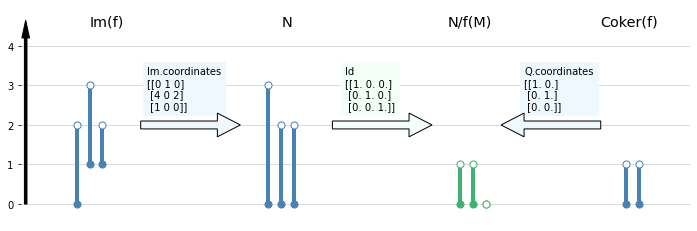

In [18]:
barcode_M_N = np.concatenate([base_M.barcode, base_N.barcode], axis=0)
base_M_N = barcode_basis(barcode_M_N)
F_Id = np.concatenate([F, np.identity(base_N.dim)], axis=1)

Q, _, = image_kernel(base_M_N, base_N, F_Id, p=5, start_index=4)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)

# plot sequence Im(f) -->  N  --> N/f(M) <-- Coker(f) ##############################################################
ax.set(frame_on=False)
ax.grid(c='lightgray')
ax.arrow(0, 0, 0, 4.2, width=0.1, color='black', zorder=2.5)
ax.set_xticks([])
ax.set_yticks(range(5))
ax.set_xlim([-0.2,26])
ax.set_ylim([-0.5,5])
# plot ker(f)
x_pos = 2
ax.text(x_pos+0.5, 4.5, "Im(f)", fontsize='x-large')
x_pos = plot_barcodes(Im.barcode, x_pos, ax, 'steelblue')
x_pos+=1
ax.text(x_pos+0.25, 2.4, "Im.coordinates\n" + str(Im.coordinates), backgroundcolor='aliceblue', zorder=2)
ax.arrow(x_pos, 2, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot N
x_pos+=5
ax.text(x_pos+0.5, 4.5, "N", fontsize='x-large')
x_pos = plot_barcodes(base_N.barcode, x_pos, ax, 'steelblue')
ax.text(x_pos+1.5, 2.4, "Id\n" + str(np.identity(3)), backgroundcolor='mintcream', zorder=2.5)
ax.arrow(x_pos+1, 2, 3, 0, width=0.2, zorder=2.5, facecolor='mintcream')
# plot N/f(M)
x_pos+=6
quotient_barcode = np.array([[0,1],[0,1],[0,0]])
ax.text(x_pos-0.5, 4.5, "N/f(M)", fontsize='x-large')
x_pos = plot_barcodes(quotient_barcode, x_pos, ax, 'mediumseagreen')# plot N/f(M)
ax.text(x_pos+1, 2.4, "Q.coordinates\n" + str(Q.coordinates), backgroundcolor='aliceblue', zorder=2)
ax.arrow(x_pos+4, 2, -3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot Coker(f)
x_pos+=5
ax.text(x_pos-1, 4.5, "Coker(f)", fontsize='x-large')
x_pos = plot_barcodes(Q.barcode, x_pos, ax, 'steelblue')

plt.savefig("figures/cokernel.png", pad_inches=0.05, bbox_inches=None)

### 2.3. Persistence Module Homology

Now we use image-kernel to compute homology of a persistence chain.

In [19]:
from permaviss.persistence_algebra.module_persistence_homology import module_persistence_homology

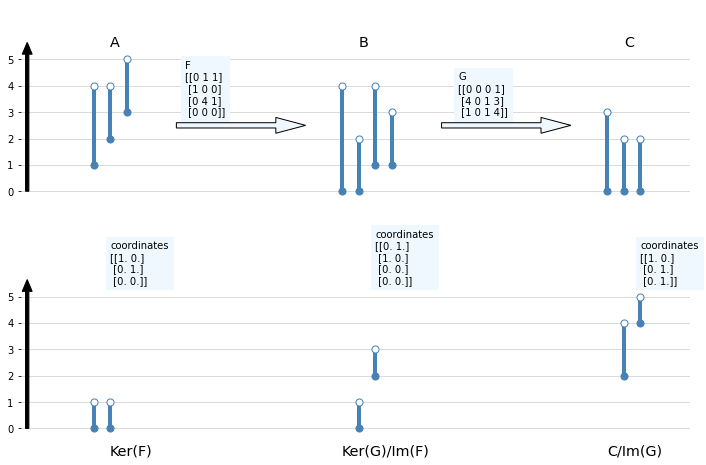

In [20]:
A = barcode_basis([[1, 4], [2, 4], [3, 5]])
B = barcode_basis([[0, 4], [0, 2], [1, 4], [1, 3]])
C = barcode_basis([[0, 3], [0, 2], [0, 2]])
Base = [C,B,A]
F = np.array([[0, 1, 1], [1, 0, 0], [0, 4, 1], [0, 0, 0]])
G = np.array([[0, 0, 0, 1], [4, 0, 1, 3], [1, 0, 1, 4]])
D = [0, G, F]
Hom, Im, PreIm = module_persistence_homology(D, Base, 5)

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

# plot sequence A --> B --> C ##############################################################
ax0.set(frame_on=False)
ax0.grid(c='lightgray')
ax0.arrow(0, 0, 0, 5.2, width=0.1, color='black', zorder=2.5)
ax0.set_xticks([])
ax0.set_yticks(range(6))
ax0.set_xlim([-0.2,20])
ax0.set_ylim([-0.5,7])
# plot ker(f)
x_pos = 2
ax0.text(x_pos+0.5, 5.5, "A", fontsize='x-large')
x_pos = plot_barcodes(A.barcode, x_pos, ax0, 'steelblue')
x_pos+=1
ax0.text(x_pos+0.25, 2.9, "F\n" + str(F), backgroundcolor='aliceblue', zorder=2)
ax0.arrow(x_pos, 2.5, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot N
x_pos+=5
ax0.text(x_pos+0.5, 5.5, "B", fontsize='x-large')
x_pos = plot_barcodes(B.barcode, x_pos, ax0, 'steelblue')
ax0.text(x_pos+1.5, 2.9, "G\n" + str(G), backgroundcolor='aliceblue', zorder=2.5)
ax0.arrow(x_pos+1, 2.5, 3, 0, width=0.2, zorder=2.5, facecolor='aliceblue')
# plot N/f(M)
x_pos+=6
ax0.text(x_pos+0.5, 5.5, "C", fontsize='x-large')
x_pos = plot_barcodes(C.barcode, x_pos, ax0, 'steelblue')# plot N/f(M)

# plot sequence Ker(F) --> Ker(G)/Im(F) --> C/Im(G) ##############################################################
ax1.set(frame_on=False)
ax1.grid(c='lightgray')
ax1.arrow(0, 0, 0, 5.2, width=0.1, color='black', zorder=2.5)
ax1.set_xticks([])
ax1.set_yticks(range(6))
ax1.set_xlim([-0.2,20])
ax1.set_ylim([-0.5,7])
# plot ker(f)
x_pos = 2
ax1.text(x_pos+0.5, -1, "Ker(F)", fontsize='x-large')
ax1.text(x_pos+0.5, 5.5, "coordinates\n" + str(Hom[0].coordinates), backgroundcolor='aliceblue')
x_pos = plot_barcodes(Hom[0].barcode, x_pos, ax1, 'steelblue')
x_pos+=1
# plot N
x_pos+=6
ax1.text(x_pos-0.5, -1, "Ker(G)/Im(F)", fontsize='x-large')
ax1.text(x_pos+0.5, 5.5, "coordinates\n" + str(Hom[1].coordinates), backgroundcolor='aliceblue')
x_pos = plot_barcodes(Hom[1].barcode, x_pos, ax1, 'steelblue')
# plot N/f(M)
x_pos+=7
ax1.text(x_pos-0.5, -1, "C/Im(G)", fontsize='x-large')
ax1.text(x_pos+0.5, 5.5, "coordinates\n" + str(Hom[2].coordinates), backgroundcolor='aliceblue')
x_pos = plot_barcodes(Hom[2].barcode, x_pos, ax1, 'steelblue')# plot N/f(M)

plt.savefig("figures/persistence_module_homology.png", pad_inches=0.05, bbox_inches=None)

# 3. Čech Homology

### 3.1. Dividing Pointclouds into Cubical Regions
We will divide now the point cloud into left and right regions. Then we compute the vietoris rips of each region, as well as the vietoris rips of the whole point cloud. Once the filtration parameter is greater to overlap we should start to see differences between the union of local Vietoris-Rips complexes and the total Vietoris-Rips complex.

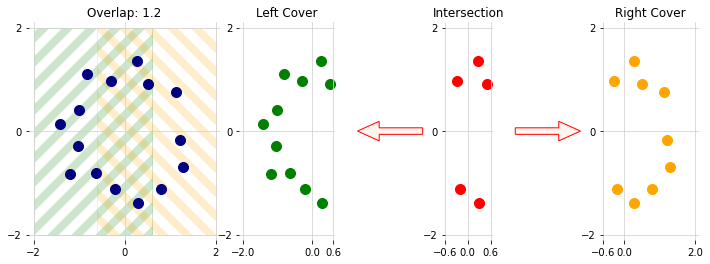

In [56]:
mpl.rcParams['hatch.linewidth'] = 8

overlap = 1.2
hoverlap = overlap/2

### Proceed to divide X into left and right regions... consider middle intersection as well ##############
# point_IN... is used to identify indices of local point cloud 
# with respect to the indices from the global point cloud X
point_IN_left = np.nonzero(X[:,0] < overlap/2)[0]
point_IN_right = np.nonzero(X[:,0] > -overlap/2)[0]
point_IN_middle = np.nonzero(np.logical_and(X[:,0] < overlap/2, X[:,0] > -overlap/2))[0]
X_left = X[point_IN_left]
X_right = X[point_IN_right]
X_middle = X[point_IN_middle]

fig = plt.figure(figsize=(12,4))

gs = fig.add_gridspec(nrows=1, ncols=6, width_ratios=[2,1,0.75,0.5,0.75,1], hspace=0)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[0,3])
ax4 = fig.add_subplot(gs[0,4])
ax5 = fig.add_subplot(gs[0,5])

# point clouds
plot_subpoints_circle(X, [-2.1,2.1], [-2,0,2], 'navy', ax0)
plot_subpoints_circle(X_left, [-2.1,hoverlap*1.1], [-2,0,hoverlap], 'green', ax1)
plot_subpoints_circle(X_middle, [-hoverlap,hoverlap*1.1], [-hoverlap,0,hoverlap], 'red', ax3)  
plot_subpoints_circle(X_right, [-hoverlap,2.1], [-hoverlap,0,2], 'orange', ax5)  

# arrows
ax2.arrow(0,0,-2,0,facecolor='seashell', edgecolor='red', width=0.3, head_length=1)
ax2.axis('off')
ax2.set_aspect('equal')

ax4.arrow(0,0,2,0,facecolor='seashell', edgecolor='red', width=0.3, head_length=1)
ax4.axis('off')
ax4.set_aspect('equal')

ax0.fill([-2,-2,hoverlap, hoverlap], [2,-2,-2,2], hatch='/', edgecolor='green', alpha=0.2, fill=False, zorder=0)
ax0.fill([2,2,-hoverlap, -hoverlap], [2,-2,-2,2], hatch='\ ', edgecolor='orange', alpha=0.2, fill=False, zorder=0)

ax0.set_title('Overlap: ' + str(overlap))
ax1.set_title('Left Cover')
ax3.set_title('Intersection')
ax5.set_title('Right Cover')

plt.savefig("figures/two_cover_circle.png", pad_inches=0.05, bbox_inches=None)

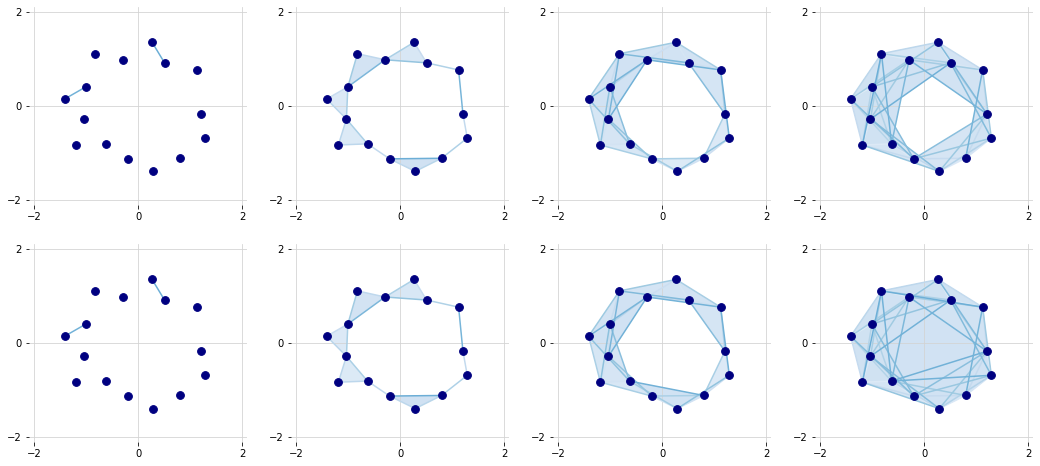

In [22]:
# euclidean distances from each local point cloud            
Dist_X_left = dist.squareform(dist.pdist(X_left))
Dist_X_right = dist.squareform(dist.pdist(X_right))
Dist_X = dist.squareform(dist.pdist(X))
 
# compute local Vietoris-Rips complexes as well as global
max_r, max_dim = 4, 3
VR_left, R_left = vietoris_rips(Dist_X_left, max_r, max_dim)
VR_right, R_right = vietoris_rips(Dist_X_right, max_r, max_dim)
VR_global, R_global = vietoris_rips(Dist_X, max_r, max_dim)

# Compute the union of Vietoris-Rips complexes from left and right
# this union has vertex indices on X
def union_simplices(dim):
    union_spx = np.concatenate((point_IN_left[VR_left[dim]], point_IN_right[VR_right[dim]]), axis=0)
    union_spx_R = np.concatenate((R_left[dim], R_right[dim]), axis=0)
    union_spx, unique_spx_idx = np.unique(union_spx, return_index=True, axis=0)[0:2]
    union_spx_R = union_spx_R[unique_spx_idx]
    order_spx = np.argsort(union_spx_R)
    return union_spx[order_spx], union_spx_R[order_spx]

union_edges, union_edges_R = union_simplices(1)
union_2spx, union_2spx_R = union_simplices(2)

VR_union = [VR_global[0], union_edges, union_2spx]
R_union = [np.zeros(VR_global[0]), union_edges_R, union_2spx_R]

         
fig = plt.figure(figsize=(18,8))

for i, max_plotting_r in enumerate([0.5,1,1.5,2]):
    ax0 = fig.add_subplot(2,4,i + 1)
    ax1 = fig.add_subplot(2,4,i + 5)
    plot_complex_noisy_circle(VR_union, R_union, max_plotting_r, X, ax0)
    plot_complex_noisy_circle(VR_global, R_global, max_plotting_r, X, ax1)
    
    
plt.show()

In [23]:
# Rewrite unsaved changes whenever possible
# VR_diff = []
# for e in VR_global[1]:
#     if list(e) not in VR_union[1].tolist():
#         VR_diff.append(e)
        
# VR_diff = np.asarray(VR_diff)

### 3.2. Computing Local Persistent Homology in parallel

In [24]:
from permaviss.spectral_sequence.spectral_sequence_class import spectral_sequence

We start by creating a spectral sequence object:

In [25]:
# create nerve two cover
nerve = [2, np.array([[0,1]])]
nerve_dim = len(nerve)
max_r, max_dim = overlap, 3
p = 5
no_pages = 2

# nerve point cloud and points IN
nerve_point_cloud = [[X_left, X_right], [X_middle]]
points_IN = [[point_IN_left, point_IN_right], [point_IN_middle]]

MV_ss = spectral_sequence(nerve, nerve_point_cloud, points_IN, max_dim,
                          max_r, no_pages, p)

MV_ss.no_columns=2 # correct number of columns

Compute the first page in parallel:

In [26]:
import time
from multiprocessing import Pool
from functools import partial

from permaviss.spectral_sequence.MV_spectral_seq import local_persistent_homology

In [27]:
# 0 PAGE ##################################################################
for n_dim in range(0, nerve_dim):
    if n_dim > 0:
        n_spx_number = np.size(nerve[n_dim], 0)
    else:
        n_spx_number = nerve[0]

    partial_persistent_homology = partial(local_persistent_homology,
                                          nerve_point_cloud,
                                          max_r, max_dim, p, n_dim)

    workers_pool = Pool()
    output = workers_pool.map(partial_persistent_homology,
                              range(n_spx_number))
    workers_pool.close()

    MV_ss.add_output_first(output, n_dim)



In [28]:
# 1 PAGE ##################################################################

# Print page
print("PAGE: 1")
flip = np.array(range(MV_ss.no_rows))
flip = -flip
print(MV_ss.page_dim_matrix[1][np.argsort(flip)])
# Loop through all rows of spectral sequence
for deg in range(max_dim):
    base = [barcode_basis(MV_ss.first_page_barcodes[0][deg])]
    differentials = [0]
    for n_dim in range(1, nerve_dim):
        base.append(barcode_basis(MV_ss.first_page_barcodes[n_dim][deg]))
        differentials.append((MV_ss.first_differential(n_dim, deg)).T)
    # end for
    Hom, Im, PreIm = module_persistence_homology(differentials, base, p)
    MV_ss.add_output_higher(Hom, Im, PreIm, 0, deg, 1)
    # compute total complex representatives for second page classes
    for n_dim in range(nerve_dim):
        if MV_ss.Hom[1][n_dim][deg].dim > 0:
            MV_ss.compute_two_page_representatives(n_dim, deg)
        # end if
    # end for
# end for

PAGE: 1
[[ 0  0]
 [ 0  0]
 [20  5]]


Let us plot these bars to see how they look like:

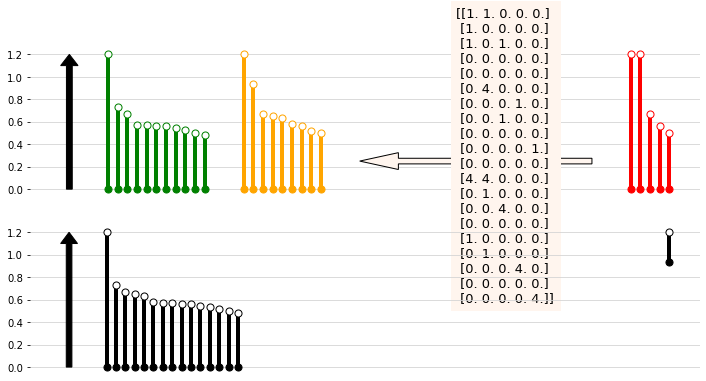

In [29]:
fig = plt.figure(figsize=(12,6))
ax0 = fig.add_subplot(2,1,1)
ax0.set(frame_on=False)
ax0.grid(c='lightgray')
ax0.arrow(0, 0, 0, overlap, width=0.3, color='black', head_length=0.1, length_includes_head=True, zorder=2.5)
ax0.set_xticks([])
x_pos = 2
plot_barcodes(MV_ss.Hom[0][0][0][0].barcode, x_pos, ax0, 'green')
x_pos += 7
plot_barcodes(MV_ss.Hom[0][0][1][0].barcode, x_pos, ax0, 'orange')
x_pos += 20
plot_barcodes(MV_ss.Hom[0][1][0][0].barcode, x_pos, ax0, 'red')

ax0.text(20,-1, str(MV_ss.first_differential(1,0).T), backgroundcolor='seashell', zorder=2.5, fontsize=13)
ax0.arrow(x_pos-2, 0.25, -10, 0, width=0.05, zorder=2.5, facecolor='seashell', head_length=2)

bases_0_row = [barcode_basis(MV_ss.first_page_barcodes[0][0]), barcode_basis(MV_ss.first_page_barcodes[1][0]), barcode_basis([])]
cech_morphisms_0_row = [0, MV_ss.first_differential(1,0).T, 0]

cech_0_homology, _, _ = module_persistence_homology(cech_morphisms_0_row, bases_0_row, p)
cech_0_homology[0].barcode

ax1 = fig.add_subplot(2,1,2)
ax1.set(frame_on=False)
ax1.grid(c='lightgray')
ax1.arrow(0, 0, 0, overlap, width=0.3, color='black', head_length=0.1, length_includes_head=True, zorder=2.5)
ax1.set_xticks([])
x_pos = 2
plot_barcodes(cech_0_homology[0].barcode, x_pos, ax1, 'black')
x_pos += 30
plot_barcodes(cech_0_homology[1].barcode, x_pos, ax1, 'black')

plt.savefig("figures/cech_diff_2_cover.png", pad_inches=0.05, bbox_inches=None)

NameError: name 'left_rep_cycle' is not defined

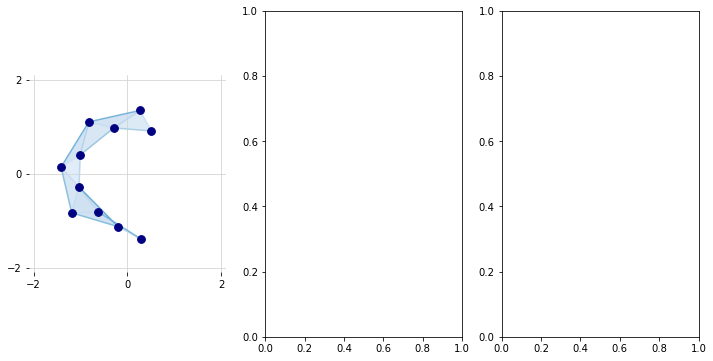

In [30]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

Dist_X_middle = dist.squareform(dist.pdist(X_middle))
 
VR_middle, R_middle = vietoris_rips(Dist_X_middle, max_r, max_dim)

plot_complex_noisy_circle(VR_left, R_left, max_r, X_left, ax1)
ax1.set_aspect('equal')

for e in left_rep_cycle:
    e_points = X_left[e]
    ax1.plot(e_points[:,0], e_points[:,1], linewidth=5, c='red', zorder=3)

plot_complex_noisy_circle(VR_middle, R_middle, max_r, X_middle, ax2)
ax2.set_aspect('equal')

plot_complex_noisy_circle(VR_right, R_right, max_r, X_right, ax3)
ax3.set_aspect('equal')

points_rep_intersect = X[rep_ker_intersect]

ax2.scatter(points_rep_intersect[:,0], points_rep_intersect[:,1], c='red', s=130, zorder=4)


plt.show()

In [ ]:
print(barcode_basis(MV_ss.first_page_barcodes[1][0]))

In [ ]:
print(cech_0_homology[1])

### 3.3. Local Chains Class

### 3.4. Čech differentials and Čech Homology

### 3.5. Illustration of some examples

# 4. Computing the spectral sequence

### 4.1. Total Complex Representatives

### 4.2. Computing Higher Pages

Here we will look at an example with a nontrivial second page differential. We will consider the Sphere with two handles.

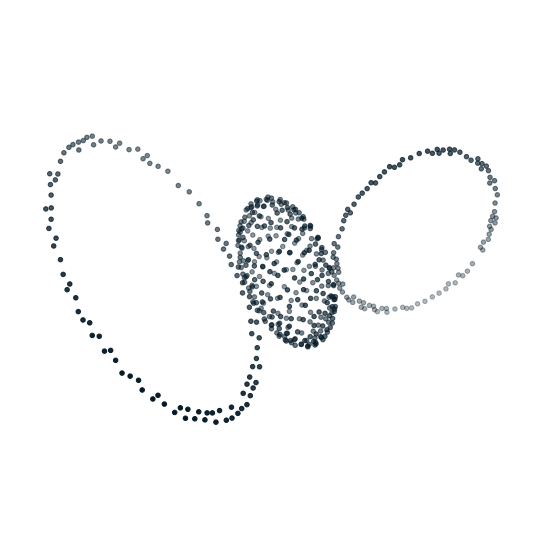

In [81]:
from permaviss.sample_point_clouds.examples import random_sphere, random_circle

np.random.seed(5)

circle1 = take_sample(random_circle(500,2,0.08,[3.3,0]),100)
circle1 = np.c_[circle1, 0.3*circle1[:,0]]
circle2 = take_sample(random_circle(500,2,0.07,[-3.3,0]),100)
circle2 = np.c_[circle2[:,0], np.zeros(len(circle2)), circle2[:,1]]
sphere = take_sample(random_sphere(2400, 1, 3), 300)
X = np.r_[circle1, circle2, sphere]

# plot sphere with two handles
fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection ="3d", xlim=[-4,4], ylim=[-2,2], zlim=[-2,2])
# Creating plot
ax.scatter3D(X[:,0], X[:,1], X[:,2], color = "#031926")
ax.axis('off')
ax.view_init(55,70)
plt.show()

Divide point cloud into three regions with some overlap whose half is given by ℎ>0
- A: 𝑧>−ℎ and 𝑥>−ℎ ,
- B: 𝑧>−ℎ and 𝑥<ℎ ,
- C:  𝑧<ℎ .

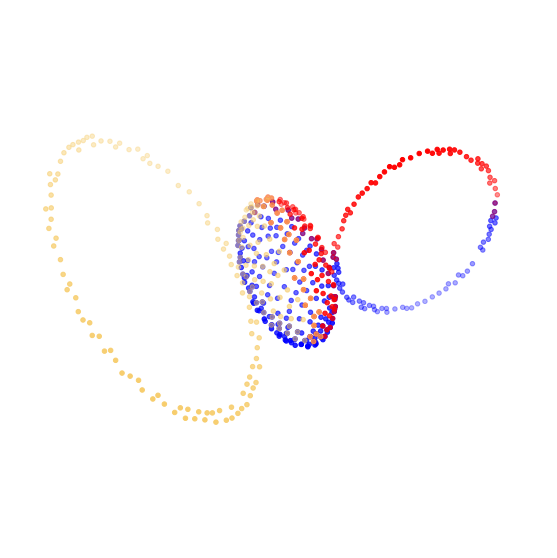

In [108]:
overlap = 0.40
halfov = overlap/2

# Get the identification numbers "IN" for each region or intersection
A = np.array([idx for idx in range(len(X)) if (X[idx][2]>-halfov)and (X[idx][0]>-halfov)])
B = np.array([idx for idx in range(len(X)) if (X[idx][2]>-halfov)and (X[idx][0]<halfov)])
C = np.array([idx for idx in range(len(X)) if (X[idx][2]<halfov)])
A_B = np.array([idx for idx in A if idx in B])
A_C = np.array([idx for idx in A if idx in C])
B_C = np.array([idx for idx in B if idx in C])
A_B_C =  np.array([idx for idx in A_B if idx in C])

# prepare nerve, nerve point cloud and points_IN for spectral sequence
nerve = [3, np.array([[0,1],[0,2],[1,2]]), np.array([[0,1,2]]), [], []]
nerve_point_cloud = [[X[A],X[B],X[C]], [X[A_B], X[A_C], X[B_C]],[], []]
points_IN = [[A,B,C], [A_B, A_C, B_C], [A_B_C], []]
if len(A_B_C)>0:
    nerve_point_cloud[2].append(X[A_B_C])
    
# additionally, we plot the three diferent regions in red, yellow and blue
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection ="3d", xlim=[-4,4],ylim=[-2,2],zlim=[-2,2]) 
# Creating plot
ax.scatter(X[A][:,0], X[A][:,1], X[A][:,2], color = "#f7cd6c")
ax.scatter(X[B][:,0], X[B][:,1], X[B][:,2], color = "red")
ax.scatter(X[C][:,0], X[C][:,1], X[C][:,2], color = "blue")
plt.axis('off')
ax.view_init(55,70)
plt.show()

Now we call the spectral sequence, step by step. First we compute local persistent homology, storing first page representatives as well.

In [83]:
n_dim = 3
max_dim = 3
max_r = overlap
no_pages = min(max_dim + 2, n_dim+1)
MV_ss = spectral_sequence(nerve, nerve_point_cloud, points_IN, max_dim,
                          max_r, no_pages, p)

In [84]:
print("computing 0 and 1st page")
# 0 PAGE ##################################################################
start = time.time()
if __name__=="__main__":
    for n_dim in range(0, nerve_dim):
        if n_dim > 0:
            n_spx_number = np.size(nerve[n_dim], 0)
        else:
            n_spx_number = nerve[0]
    
        partial_persistent_homology = partial(local_persistent_homology,
                                              nerve_point_cloud,
                                              max_r, max_dim, p, n_dim)
    

        workers_pool = Pool()
        output = workers_pool.map(partial_persistent_homology,
                                  range(n_spx_number))
        workers_pool.close()
        MV_ss.add_output_first(output, n_dim)

print("first page computation: {}".format(time.time()-start))

computing 0 and 1st page
first page computation: 168.91810965538025


Proceed to compute higher pages

In [85]:
# 1 PAGE ##################################################################

# Print page
print("PAGE: 1")
flip = np.array(range(MV_ss.no_rows))
flip = -flip
print(MV_ss.page_dim_matrix[1][np.argsort(flip)])
# Loop through all rows of spectral sequence
for deg in range(max_dim):
    base = [barcode_basis(MV_ss.first_page_barcodes[0][deg])]
    differentials = [0]
    for n_dim in range(1, nerve_dim):
        base.append(barcode_basis(MV_ss.first_page_barcodes[n_dim][deg]))
        differentials.append((MV_ss.first_differential(n_dim, deg)).T)
    # end for
    print("module pers hom time, deg:{}".format(deg))
    start = time.time()
    Hom, Im, PreIm = module_persistence_homology(differentials, base, p)
    print(time.time()-start)
    MV_ss.add_output_higher(Hom, Im, PreIm, 0, deg, 1)
    # compute total complex representatives for second page classes
    for n_dim in range(nerve_dim):
        if MV_ss.Hom[1][n_dim][deg].dim > 0:
            MV_ss.compute_two_page_representatives(n_dim, deg)
        # end if
    # end for
# end for

# PAGES => 2 ##############################################################

for current_page in range(2, no_pages):
    # Print page
    print("PAGE: {}".format(current_page))
    flip = np.array(range(MV_ss.no_rows))
    flip = -flip
    print(MV_ss.page_dim_matrix[current_page][np.argsort(flip)])
    start = time.time()

    # Loop through sequences of possibly nontrivial differentials
    # current_page columns
    for start_n_dim in range(current_page):
        for start_deg in range(max_dim):
            deg = start_deg
            n_dim = start_n_dim
            differentials = [0]
            base = [MV_ss.Hom[current_page - 1][n_dim][deg]]
            # While (n_dim, deg) lies within the spectral sequence
            # boundaries
            while deg >= 0 and n_dim < nerve_dim:
                # Advance to differential domain and compute differential
                deg += 1 - current_page
                n_dim += current_page
                if deg >= 0 and n_dim < nerve_dim:
                    differentials.append(MV_ss.high_differential(
                        n_dim, deg, current_page).T)
                    base.append(MV_ss.Hom[current_page - 1][n_dim][deg])
                # end if
            # end while
            Hom, Im, PreIm = module_persistence_homology(differentials,
                                                         base, p)
            MV_ss.add_output_higher(Hom, Im, PreIm, start_n_dim, start_deg,
                                    current_page)

            # adjust reps of im and create reps for next hom
            deg = start_deg
            n_dim = start_n_dim
            while deg >= 0 and n_dim < nerve_dim:
                # compute total complex reps for next page classes
                MV_ss.compute_higher_representatives(
                    n_dim, deg, current_page)
                deg += 1 - current_page
                n_dim += current_page
                # end if
            # end while
        # end for
    # end for
    print("time:{}".format(time.time()-start))
# end for

PAGE: 1
[[  0   0   0   0   0]
 [187  15   1   0   0]
 [599 106   7   0   0]]
module pers hom time, deg:0
7.081144571304321
module pers hom time, deg:1
0.5699994564056396
module pers hom time, deg:2
0.0
PAGE: 2
[[  0   0   0   0   0]
 [173   0   0   0   0]
 [500   8   1   0   0]]
time:17.328076124191284
PAGE: 3
[[  0   0   0   0   0]
 [172   0   0   0   0]
 [500   8   1   0   0]]
time:0.01200103759765625


Next we interpret the representatives to see what has happened. 

In [113]:
MV_ss.Hom_reps[1][2][0][1].coord[0][0]


1.0

In [114]:
print(MV_ss.Hom[1][2][0].barcode)
print(MV_ss.Hom[2][2][0].barcode)

[[0.2998954 0.4      ]]
[[0.38478055 0.4       ]]


In [117]:
len(MV_ss.subcomplexes[1])

3

In [237]:
def plot_edges(point_cloud, edges, color, axis):
    for edge in edges:
        points = point_cloud[edge]
        axis.plot3D(points[:,0], points[:,1], points[:,2], c=color, lw=6)

In [238]:
print(MV_ss.Im[2][0][1].barcode)

[[0.2998954  0.38478055]]


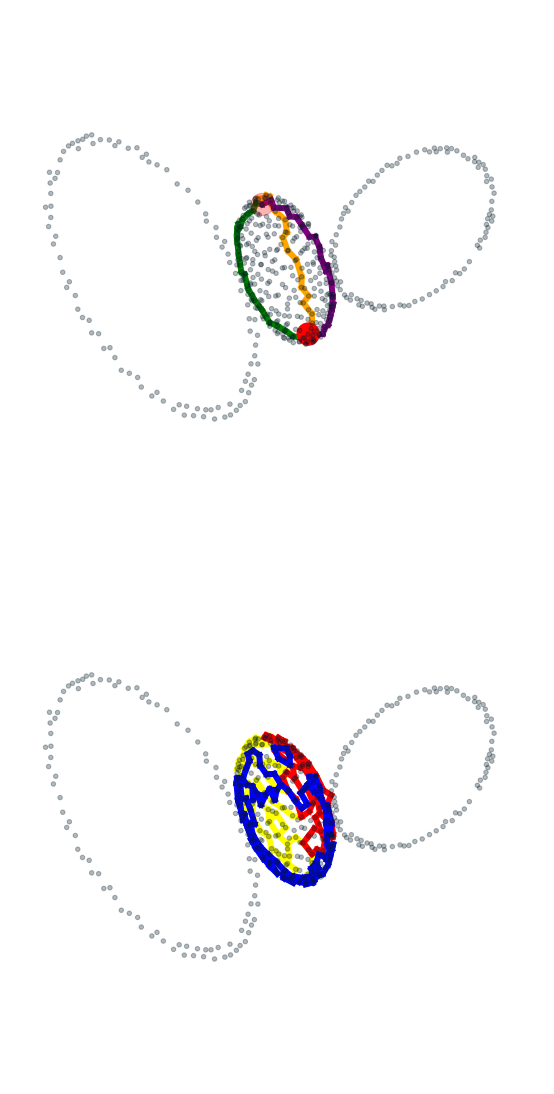

In [255]:
from permaviss.gauss_mod_p.functions import multiply_mod_p

# plot sphere with two handles
fig = plt.figure(figsize = (20, 15))
fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
ax0 = fig.add_subplot(2,1,1,projection ="3d", xlim=[-4,4], ylim=[-2,2], zlim=[-2,2])
ax1 = fig.add_subplot(2,1,2,projection ="3d", xlim=[-4,4], ylim=[-2,2], zlim=[-2,2])

def plot_3d_points(point_cloud, axis, color):
    # Creating plot
    axis.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], color = color, alpha=0.3)
    axis.axis('off')
    axis.view_init(55,70)

plot_3d_points(X, ax0, "#031926")
plot_3d_points(X, ax1, "#031926")

# representative points 3 class
rep_points = X[points_IN[2][0][np.nonzero(MV_ss.Hom_reps[1][2][0][0].coord[0][0])[0]]]
ax0.scatter(rep_points[:,0], rep_points[:,1], rep_points[:,2], color="red", s=500)

# representative edges 2 intersection
colors = ['orange', 'green', 'purple']
for i in range(3):
    edges = points_IN[1][i][MV_ss.subcomplexes[1][i][1][np.nonzero(MV_ss.Hom_reps[1][2][0][1].coord[i][0])[0]]]
    plot_edges(X, edges, colors[i], ax0)
    
# representative local cycles
cycles = np.nonzero(
    multiply_mod_p(MV_ss.Hom[1][0][1].coordinates, MV_ss.Im[2][0][1].coordinates, p=5)
)[0]
colors = ['yellow', 'red', 'blue']
for i in range(3):
    local_cycles = cycles[np.logical_and(
        MV_ss.cycle_dimensions[0][1][i-1] <= cycles,  cycles< MV_ss.cycle_dimensions[0][1][i]
        )] - MV_ss.cycle_dimensions[0][1][i-1]
    local_cycles = MV_ss.Hom[0][0][i][1].coordinates[:, local_cycles].T
    local_edges = []
    for cycle in local_cycles:
        local_edges.append(list(np.nonzero(cycle)[0]))
    
    local_edges = MV_ss.points_IN[0][i][MV_ss.subcomplexes[0][i][1][np.unique(np.concatenate(local_edges))]]
    plot_edges(X, local_edges, colors[i], ax1)
    
ax0.autoscale_view(tight=True)
ax1.autoscale_view(tight=True)

plt.savefig("figures/second_differential_sphere_two_handles.png", pad_inches=0.05, bbox_inches=None)

### 4.3. Extension Problem

# 5. A brief example Using PerMaViss
### 5.1. Computing the spectral sequence

Include example of going over maximum filtration value and compare differences in persistent homology

### 5.2. Plotting the Results

# 6. Conclusion

There are still a few functions to include in PerMaViss...

I hope you enjoyed the tutorial! 